# Merging the rail network and population density datasets

## Check that the required datasets exist

The datasets required are `nerails_simplified.graphml` and `popdensity.tif` (see notebooks `DataLoading` and `PopulationDensity`)

In [1]:
from os import path

data_folder = 'data'
rails_name = path.join(data_folder, 'nerails_simplified.graphml')
pop_name = path.join(data_folder, 'popdensity.tif')

if path.exists(rails_name):
    print('ok')
else: 
    print('not found:', rails_name)
    
if path.exists(pop_name):
    print('ok')
else: 
    print('not found:', pop_name)

ok
ok


## Add population data to nodes

In [2]:
from os import path
import numpy as np
import osmnx as ox
import pandas as pd
from pyproj import CRS, Transformer
import georasters as gr


ox.config(log_console = True, data_folder = 'data')

data_folder = 'data'
rails_src = 'nerails_simplified.graphml'
pop_src = 'popdensity.tif'

graph = ox.load_graphml(rails_src)
pop = gr.from_file(path.join(data_folder, pop_src))

crs_source = CRS.from_wkt(pop.projection.ExportToWkt())
crs_latlon = CRS.from_epsg(4326)
transformer_to_latlon = Transformer.from_crs(crs_source, crs_latlon)
transformer_from_latlon = Transformer.from_crs(crs_latlon, crs_source)

def to_latlon(north, east): return transformer_to_latlon.transform(north, east)
def from_latlon(lat, lon): return transformer_from_latlon.transform(lat, lon)

def _pop_for_coords(lat, lon):
    try:
        return pop.map_pixel(*from_latlon(lat, lon))
    except:
        return 0
    
def pop_for_coords(lat, lon):
    row, col = pop.map_pixel_location(*from_latlon(lat, lon))
    S = 0.
    for i in range(-1,2):
        for j in range(-1,2):
            val = 0.
            try:
                val = pop.raster[row+i][col+j]
            except:
                val = 0
            if val < 0:
                val = 0
            S += val
    return S
    
for n in graph.nodes:
    node = graph.nodes[n]
    node['population'] = pop_for_coords(node['y'], node['x'])
ox.save_graphml(graph, 'nerails_with_pop.graphml')
print('Result saved')

Result saved


## Node examples

12.140581116080284
0.0
412.59393978118896
599.0966997146606
4740.488922119141
713.6344089508057
1113.0610046386719
630.4472160339355
944.896276473999
151.0698208808899


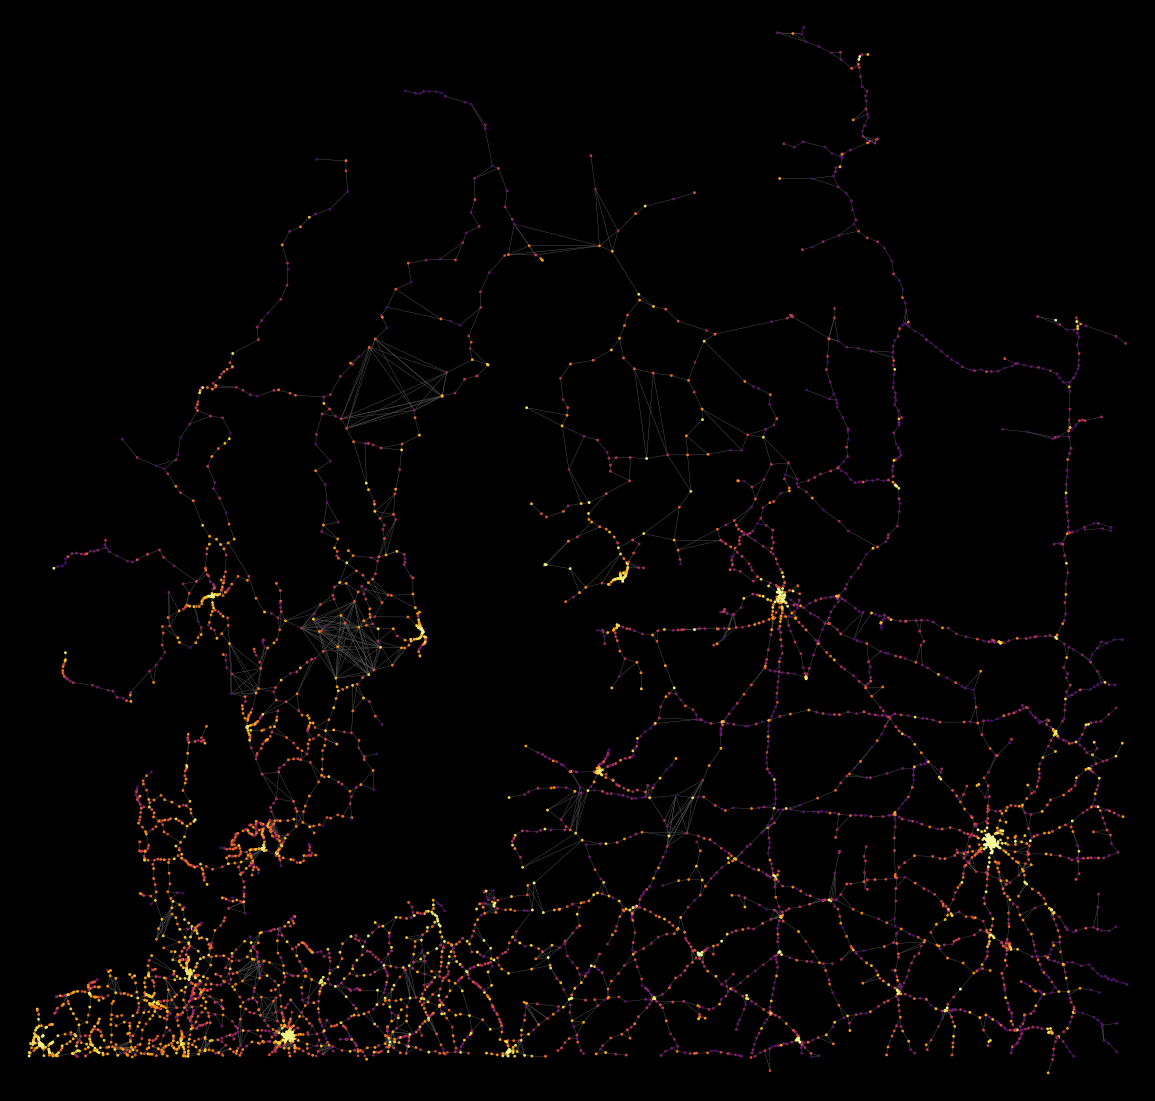

In [3]:
from os import path
import osmnx as ox
import random

ox.config(log_console = True, data_folder = 'data')
src = 'nerails_with_pop.graphml'
graph = ox.load_graphml(src)
nodes = graph.nodes
random.seed(0)

for node in graph.nodes:
    pop = graph.nodes[node]['population']
    try:
        pop = float(pop)
    except:
        pop = 0.
    graph.nodes[node]['population'] = pop

for node in random.sample(nodes, 10):
    print(nodes[node]['population'])

def plot_graph(series, G):
    df = pd.DataFrame(data=pd.Series(series).sort_values(), columns=['cc'])
    df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
    df = df.reindex(graph.nodes())
    nc = df['colors'].tolist()
    fig, ax = ox.plot_graph(
        G, 
        bgcolor='k', 
        node_size=8, 
        node_color=nc, 
        node_edgecolor='none', 
        node_zorder=2,
        edge_color='#555555', 
        edge_linewidth=0.25, 
        edge_alpha=1, 
        fig_height=20
    )

colors = {node['osmid']: node['population'] for node in graph.nodes.values()}
plot_graph(colors, graph)